There are a lot of satellites gathering a lot of imagery of the earth, day in day out. The government-subsidized and freely available data from Landsat-8 and Sentinel-2 missions have a maximum spatial resolution of 15m ([Landsat-8 panchromatic band](https://en.wikipedia.org/wiki/Landsat_8#Sensors)) and 10m ([Sentinel-2 R/G/B/NIR bands](https://en.wikipedia.org/wiki/Sentinel-2#Instruments)), respectively. Free imagery at such a high resolution is pretty cool!

Sentinel-2 has a revisit time of ~5 days, meaning it will view the same plot of land at about the same angle every 5 days. However, the pointing accuracy is never perfect, so the pixels are never *exactly* in the same place. The question in my mind is: can we use multiple images over time to effectively do "superresolution"?

## Getting data
I'm using [Level-2A data](https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a) as this gives me Bottom-of-Atmosphere (BOA) reflectance, while the Level-1C product gives Top-of-Atmosphere reflectance. The TOA reflectance is basically what the satellite "sees", but can be much more "hazy" by going back up through the atmosphere. The BOA reflectance is what we'd estimate the surface reflects, which makes it look less "hazy" and will hopefully reduce differences in images a bit.

![L2A illustration](/Sentinel-2-Level-1C-Level-2A-TOA.jpg)
<br>*Image from [ESA](https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a)*

<!-- TEASER_END -->

I obtained this imagery through the app at [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) by manually filtering for imagery with a low cloud percentage, centered over Amsterdam. I chose only full tiles where the satellite has approximately the same viewing and solar angle (the satellite is in sun-synchronous orbit, but the hub might show images one swath to the right or left of your selected location). An API is also provided and might be more convenient for downloading large amounts of data.

I unpacked this data and put it in folder `sentinel/`. The data packages are a bit obtuse but the format is well-described ([naming conventions](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention), [SAFE format](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats)), and they even include free banners!

![Sentinel banner](/sentinel_banner_2.png)
<br>*Free banner included with the free data*

In [ ]:
import os, re
from glob import glob
from datetime import datetime
from collections import defaultdict

from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.ndimage

FIGSIZE = (14, 7)

In [2]:
da = xr.open_rasterio("sentinel/S2B_MSIL2A_20190401T105029_N0211_R051_T31UFU_20190401T140125.SAFE/GRANULE/L2A_T31UFU_A010802_20190401T105221/IMG_DATA/R10m/T31UFU_20190401T105029_B02_10m.jp2")
da

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
[120560400 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06 5.79e+06
  * x        (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
Attributes:
    transform:   (10.0, 0.0, 600000.0, 0.0, -10.0, 5900040.0)
    crs:         +init=epsg:32631
    res:         (10.0, 10.0)
    is_tiled:    1
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

Upon inspection of this one JPEG2000 file for the B band at one timestep, we see that the projection is [EPSG:32631](https://epsg.io/32631), which is UTM zone 31N. Xarray/rasterio has been able to extract this from the embedded metadata. The image is quite large, with sides at over 10k pixels, so I used [this tool](https://epsg.io/map#srs=32631&x=640077.25&y=5794953.27&z=10&layer=streets) to get a tight bounding box directly in UTM coordinates which we will use to crop the images to make them a bit easier to work with. (Doing optical flow on 10k x 10k pixels is not much fun.)

In [3]:
# Bounding box in UTM 31N coordinates
extent = dict(x=slice(621954, 640077), y=slice(5811457,5794953))

data_arrays = defaultdict(list)

for p in sorted(glob("sentinel/S2B_MSIL2A_*/GRANULE/*/IMG_DATA/R10m/*_B0*_10m.jp2")):
    # How I learned to stop worrying and love the walrus syntax in Python 3.8
    if m := re.match("^.*_(.+)_B(0[234])_.*$", p):
        dt = datetime.strptime(m.group(1), "%Y%m%dT%H%M%S")
        band = int(m.group(2))
        # Returns a DataArray
        da = xr.open_rasterio(p).sel(**extent)
        da.coords["band"] = [band]
        da.coords["dt"] = dt
        data_arrays[band].append(da)

# Use a nested concat to put these data arrays back together in one big data array
d = xr.concat([xr.concat(data_arrays[k], dim="dt") for k in sorted(data_arrays.keys())], dim="band")
d

<xarray.DataArray (dt: 6, band: 3, y: 1651, x: 1813)>
array([[[[335, 295, 283, ..., 422, 425, 357],
         [289, 275, 272, ..., 415, 364, 265],
         [291, 255, 270, ..., 392, 398, 357],
         ...,
         [503, 528, 438, ..., 223, 227, 215],
         [502, 536, 503, ..., 208, 205, 207],
         [516, 505, 540, ..., 208, 239, 344]],

        [[567, 559, 546, ..., 725, 728, 585],
         [568, 540, 521, ..., 720, 644, 397],
         [561, 513, 521, ..., 719, 670, 570],
         ...,
         [758, 705, 651, ..., 430, 435, 448],
         [747, 653, 629, ..., 439, 459, 500],
         [664, 617, 642, ..., 437, 462, 586]],

        [[367, 341, 313, ..., 497, 479, 442],
         [301, 259, 259, ..., 467, 452, 353],
         [290, 270, 271, ..., 465, 471, 461],
         ...,
         [674, 684, 613, ..., 165, 179, 186],
         [623, 644, 625, ..., 167, 168, 234],
         [650, 701, 730, ..., 146, 220, 369]]],


       [[[416, 397, 389, ..., 483, 480, 424],
         [386, 396, 407, ..., 485, 450, 405],
         [399, 372, 401, ..., 456, 444, 441],
         ...,
         [604, 699, 645, ..., 399, 412, 405],
         [708, 681, 673, ..., 412, 412, 425],
         [672, 706, 694, ..., 427, 427, 474]],

        [[714, 686, 731, ..., 779, 761, 648],
         [753, 744, 727, ..., 776, 698, 559],
         [753, 722, 745, ..., 761, 734, 677],
         ...,
         [805, 838, 780, ..., 599, 607, 595],
         [868, 808, 774, ..., 619, 615, 610],
         [774, 735, 755, ..., 643, 631, 710]],

        [[386, 377, 375, ..., 465, 454, 415],
         [403, 363, 353, ..., 429, 426, 409],
         [397, 373, 352, ..., 434, 424, 421],
         ...,
         [634, 707, 684, ..., 297, 311, 296],
         [802, 748, 739, ..., 301, 319, 310],
         [736, 777, 821, ..., 319, 344, 469]]],


       [[[465, 438, 444, ..., 526, 498, 422],
         [435, 454, 460, ..., 533, 500, 406],
         [434, 465, 454, ..., 561, 569, 514],
         ...,
         [656, 639, 513, ..., 448, 451, 440],
         [747, 764, 656, ..., 448, 457, 469],
         [702, 736, 739, ..., 433, 478, 519]],

        [[725, 744, 741, ..., 839, 792, 673],
         [738, 744, 761, ..., 849, 775, 626],
         [744, 755, 759, ..., 864, 841, 790],
         ...,
         [897, 813, 685, ..., 718, 718, 686],
         [930, 827, 782, ..., 699, 693, 741],
         [822, 789, 774, ..., 693, 718, 814]],

        [[491, 456, 456, ..., 711, 627, 486],
         [461, 434, 463, ..., 754, 615, 445],
         [470, 487, 472, ..., 777, 702, 641],
         ...,
         [777, 700, 518, ..., 592, 565, 567],
         [856, 861, 720, ..., 573, 590, 633],
         [858, 841, 818, ..., 551, 683, 711]]],


       [[[359, 345, 346, ..., 479, 443, 375],
         [346, 321, 357, ..., 452, 387, 339],
         [342, 325, 346, ..., 451, 446, 448],
         ...,
         [553, 619, 619, ..., 335, 366, 367],
         [547, 598, 645, ..., 361, 371, 412],
         [552, 613, 637, ..., 354, 408, 436]],

        [[582, 539, 563, ..., 690, 656, 473],
         [545, 549, 569, ..., 626, 558, 398],
         [537, 577, 588, ..., 616, 612, 533],
         ...,
         [771, 742, 725, ..., 561, 589, 566],
         [720, 672, 725, ..., 598, 559, 549],
         [608, 600, 668, ..., 594, 571, 661]],

        [[425, 372, 347, ..., 601, 553, 433],
         [351, 314, 325, ..., 592, 527, 399],
         [347, 331, 370, ..., 581, 553, 511],
         ...,
         [629, 726, 751, ..., 306, 404, 415],
         [586, 641, 731, ..., 398, 403, 425],
         [576, 666, 666, ..., 420, 448, 541]]],


       [[[336, 325, 320, ..., 491, 465, 359],
         [336, 312, 287, ..., 465, 402, 326],
         [325, 336, 350, ..., 473, 452, 408],
         ...,
         [537, 583, 547, ..., 339, 329, 289],
         [577, 597, 640, ..., 290, 300, 339],
         [543, 591, 540, ..., 297, 341, 438]],

        [[579, 572, 594, ..., 729, 709, 527],
         [604, 589, 597, ..., 689, 581, 430],
         [611, 589, 612, ..., 680, 641, 581],
    

One can make [many different band combinations](https://gisgeography.com/sentinel-2-bands-combinations/) for different purposes, we are mostly interested in "natural colors" to make good-looking pictures.

Visualising this imagery in natural colors properly is not entirely straightforward, we'd need to account for human perception, sensor properties and more. I found one [exceptionally good paper](https://www.sciencedirect.com/science/article/pii/S0034425719300422/pdfft) ([code](https://github.com/sentinel-hub/natural-color)) that explains everything about improving this mapping. The default Sentinel-2 True Color Image (TCI) provided in the data granule uses the basic method of mapping bands 4, 3, 2 to R, G, B and applies some gain and gamma correction in the sRGB space.

I'll just go with the simple method for now, as our constraints here are not so stringent. It just has to look cool.

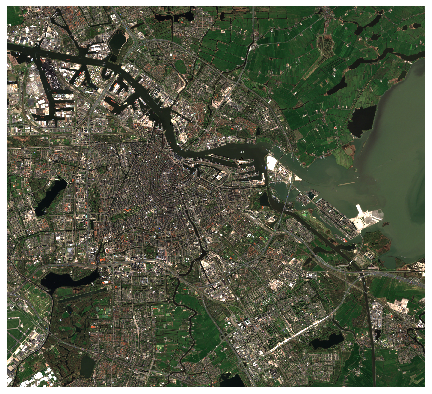

In [4]:
fig = plt.figure(figsize=FIGSIZE)

v = d.isel(dt=0).transpose("y", "x", "band").sortby("band", ascending=False).values
plt.axis("off")
plt.imshow((v / np.quantile(v.flatten(), .99)).clip(0,1));

All right! We now have multiple high-resolution images of Amsterdam. We'll have to zoom in a bit to see individual pixels.

## Estimating subpixel shift using optical flow

To find our assumed inaccuracies in sensor pointing between images, we can use optical flow techniques. I had used these algorithms before but never really dove into the math behind it, which actually turns out to be a lot of fun. So let's go into that for a second.

The basic idea of [optical flow](https://en.wikipedia.org/wiki/Optical_flow) is to assume that intensity of pixels is constant, and then assume these pixels move a little bit from one to the next frame. That results in this equation, $I_x$ and $I_y$ are the derivative of intensity over both axes, and $V_x$ and $V_y$ are the velocity or... [*optical flow*](https://youtu.be/F8mYLi3PGOc) over both axes:

$$I_x V_x + I_y V_y = - I_t$$

This basically says, in my mind, that the sum of x and y intensity gradient of a pixel must be equal to its time derivative of change. Which makes sense, because we'd expect the intensity of a pixel that has very different neighboring pixels (steep gradient) to change a lot when the scene moves.

However, we see that this equation has two unknowns. Even if we know the time rate of change, so if we measure the pixel intensity between two frames, we cannot differentiate between vertical or horizontal movement. We could solve it in a one-dimensional image (row of pixels), but not in two. This is the "aperture problem" and must be overcome by making additional assumptions, which all optical flow algorithms do.

The popular [Lucas-Kanade method](https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method) uses the assumption that all pixels in a neighborhood have a similar flow, and solves the equation above for all pixels *in a neighborhood* by applying least-squares optimization. This linear system can be represented as (equation shamelessly copied from wikipedia):

$$
\begin{bmatrix}
I_x(q_1) & I_y(q_1) \\[10pt]
\vdots  & \vdots  \\[10pt]
I_x(q_n) & I_y(q_n) 
\end{bmatrix}
\begin{bmatrix}
V_x\\[10pt]
V_y
\end{bmatrix}
=
\begin{bmatrix}
-I_t(q_1) \\[10pt]
\vdots  \\[10pt]
-I_t(q_n)
\end{bmatrix} 
$$

Where $I$ and $V$ are intensity and pixel velocity, as before, and $q$ is a pixel. The system is overconstrained and can only be solved by an optimization technique like least-squares, to find the "most reasonable" motion vector according to some criteria.

The unknown is the $V$ vector, which, if you define a separate $V$ for every pixel (there is one $V$ for all pixels in the equation above), basically forms lines in the x/y space. I am quite interested to see what that looks like!

In [5]:
# Use a fixed order of the axes for easier processing
d2 = d.transpose("dt", "band", "y", "x").astype(np.float32)

FRAME = 0

# The only time it's acceptable to start a variable name with a capital is when making it closer to a math equation
Ix = scipy.ndimage.sobel(d2.isel(band=0, dt=FRAME).values, axis=0).flatten()
Iy = scipy.ndimage.sobel(d2.isel(band=0, dt=FRAME).values, axis=1).flatten()
It = np.diff(d2.isel(band=0, dt=slice(FRAME, FRAME+2)).values, axis=0)[0].flatten()

# Now we make a range of x velocities to match the y velocities and make lines
v_x = np.linspace(-.2, .2, 2)

v_y = -((Ix * v_x[:,np.newaxis]) + It)

In [6]:
# Least-squares solution
A = np.stack([Ix, Iy])
x_lstsq = np.linalg.lstsq(A.T, It, rcond=None)[0]
x_lstsq

array([ 0.03629533, -0.01984318], dtype=float32)

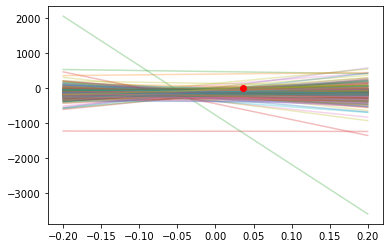

In [7]:
x = (np.ones(v_y.shape[1]) * v_x[:,np.newaxis])
N = 10000
plt.plot(x[:,::N], v_y[:,::N], alpha=.3)
plt.plot(*x_lstsq, "ro");

Okay, that does not look very interesting, and it's not very obvious to see the solution point. Maybe a heatmap would work better. Anyhow, let's calculate the optical flow for every image, compared to the first image, to get an idea of the pointing accuracy. We do this over the *full* image, as our assumption is that the pointing error is constant.

In [8]:
def solve_of(arr):
    "Solve 1st-order optical flow equations using least squares"
    Ix = scipy.ndimage.sobel(arr[0], axis=0).flatten()
    Iy = scipy.ndimage.sobel(arr[0], axis=1).flatten()
    It = np.diff(arr[:2], axis=0)[0].flatten()

    A = np.stack([Ix, Iy])
    s = np.linalg.lstsq(A.T, It, rcond=None)[0]
    return s, A, It

arr = []
for i in range(len(d)):
    # Sum all bands to lower effect of noise
    s, A, It = solve_of(d2.isel(dt=[0, i]).sum(dim="band").values)
    arr.append(s)
    # Calculate the error decrease when we apply the pixel intensity given by solution
    p1 = d2.isel(dt=0).sum(dim="band").values
    p2 = d2.isel(dt=i).sum(dim="band").values
    err1 = np.abs(p1-p2).mean()
    err2 = np.abs(p1+(A.T @ s).reshape(p1.shape) - p2).mean()
    print(f"Motion vector for frame 0 to {i+1}:", "{:6.3f} {:6.3f}".format(*s), "; err decrease: {:5.1f} -> {:5.1f}".format(err1, err2))

print("Standard deviation of motion vectors: {:6.3f} {:6.3f}".format(*np.std(np.stack(arr), axis=0)))

Motion vector for frame 0 to 1:  0.000  0.000 ; err decrease:   0.0 ->   0.0
Motion vector for frame 0 to 2:  0.039 -0.021 ; err decrease: 361.0 -> 352.5
Motion vector for frame 0 to 3:  0.035  0.035 ; err decrease: 503.5 -> 495.2
Motion vector for frame 0 to 4:  0.038  0.016 ; err decrease: 315.8 -> 300.1
Motion vector for frame 0 to 5:  0.030  0.009 ; err decrease: 310.1 -> 299.7
Motion vector for frame 0 to 6:  0.058  0.034 ; err decrease: 335.2 -> 302.8
Standard deviation of motion vectors:  0.017  0.019


Cool, we get reasonable solutions and when we try to adjust pixel intensity, we do get a better solution of the optical flow equation. So at least the found solutions give a reasonable solution to the optical flow equation.

I did a few more experiments (not shown here) using different bands and different pairs of images, and the results there seem to be reasonably consistent, which is good. These pointing errors are quite low though, which is very impressive given that this satellite flies at 786km altitude over the earth's surface. I don't think it's really possible to do anything like superresolution, for which you'd need much larger deviations to be able to "stack" the pixels.

Let's plot this data one more time and then be done with it.

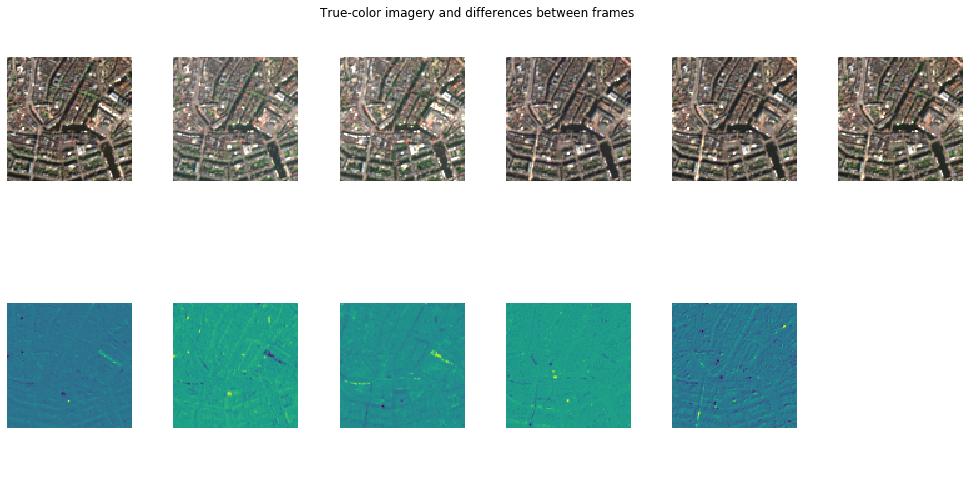

In [9]:
SCALE = 1500
X = 670
Y = 730
SIZE = 100

xslice = slice(X, X + SIZE)
yslice = slice(Y, Y + SIZE)

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=FIGSIZE)

fig.suptitle("True-color imagery and differences between frames")
fig.tight_layout()

for i in range(0, 6):
    v = d2.isel(dt=i, x=xslice, y=yslice).transpose("y", "x", "band").sortby("band", ascending=False).values
    ax[0, i].axis("off")
    # Show original image
    ax[0, i].imshow((v / SCALE).clip(0,1))

    ax[1, i].axis("off")
    if i + 1 < len(d2):
        # Difference for summed bands
        ax[1, i].imshow((d2.isel(dt=i, x=xslice, y=yslice) - d2.isel(dt=i+1, x=xslice, y=yslice)).sum(dim="band"))

It's quite amazing how well these images overlap. I tried upsampling by 100x and then moving pixels a few rows (according to the optical flow solution) to see if the textures seen in the second row would disappear, but they would not, so I assume these are also simply differences due to different sun positions and reflections.

## Conclusion

Well, that was fun! It turns out that the pointing accuracy of the SENTINEL-2 MSI instruments is very high, with a standard deviation of just a few decimeters on a distance of 786km. (Assuming our optical flow calculations are correct.) Very impressive.